In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import logging
import os

import matplotlib.pyplot as plt

import core.config as cconfig
import core.plotting as coplotti
import core.statistics as costatis
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hgit as hgit
import helpers.hparquet as hparque
import helpers.hprint as hprint

/app/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton
Don't recognize host: host_os_name=Linux, am_host_os_name=Linux


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-18a0f1ac-e6af-46e9-a2c9-a3dc18dddd89.json'
INFO  # Git
  branch_name='CmTask8000_-Add-loading-the-config-from-the-environment'
  hash='13a32f0e4'
  # Last commits:
    * 13a32f0e4 tamriq   CmTask8000: add loading config from the env                       (  22 hours ago) Wed May 1 14:07:09 2024  (HEAD -> CmTask8000_-Add-loading-the-config-from-the-environment, origin/CmTask8000_-Add-loading-the-config-from-the-environment)
    * 2e9c2e160 Shayan   Monitoring configuration modifications (#8127)                    (    2 days ago) Tue Apr 30 16:30:02 2024  (origin/CmTask8110_Rename_Tokyo_trading_DAGs)
    * 73afee1a3 Shayan   Update infrastructure services reference (#8070)                  (    2 days ago) Tue Apr 30 16:12:17 2024           
# Machine info
  system=Linux
  node name=b01b8e75f790
  release=5.15.0-1056-aws
  version=#61~20.04.1-Ubuntu SMP Wed Mar 13 17:40:41 U

# Build config

In [4]:
# Get config from env when running the notebook via the run_notebook.py script.
default_config = cconfig.get_config_from_env()
if default_config:
    _LOG.info("Using config from env vars")
else:
    _LOG.info("Using hardwired config")
    amp_dir = hgit.get_amp_abs_path()
    dir_name = os.path.join(
        amp_dir,
        "/shared_data/backtest.danya/build_tile_configs.C13a.ccxt_v7_5-all.2T.2023-06-01_2024-01-31.ins.run0/tiled_results",
    )
    cols = ["f1"]
    default_config_dict = {
        "dir_name": dir_name,
        "asset_id": 1467591036,
        "asset_id_col": "asset_id",
        "resampling_frequency": "2T",
        "feature_column_names": cols,
        "single_feature_column_name": "f1",
    }
    # Build config from dict.
    default_config = cconfig.Config().from_dict(default_config_dict)
print(default_config)

INFO  Using hardwired config
dir_name: /shared_data/backtest.danya/build_tile_configs.C13a.ccxt_v7_5-all.2T.2023-06-01_2024-01-31.ins.run0/tiled_results
asset_id: 1467591036
asset_id_col: asset_id
resampling_frequency: 2T
feature_column_names: ['f1']
single_feature_column_name: f1


# Report tile metadata

In [5]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    default_config["dir_name"]
)

In [6]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1464553467,2,8,8,12.3 MB
1467591036,2,8,8,12.2 MB


In [7]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

n_asset_ids    size
year month                     
2023 6                2  3.0 MB
     7                2  3.0 MB
     8                2  2.9 MB
     9                2  2.9 MB
     10               2  3.1 MB
     11               2  3.0 MB
     12               2  3.2 MB
2024 1                2  3.3 MB

In [8]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1464553467, 1467591036]

# Load features

In [9]:
asset_batch_size = len(asset_ids)
# Add the `asset_id_col` to also display the instruments. This is also required
# to make `yield_parquet_tiles_by_assets()` work.
requested_columns = [default_config["asset_id_col"]] + default_config[
    "feature_column_names"
]
tile_iter = hparque.yield_parquet_tiles_by_assets(
    default_config["dir_name"],
    asset_ids,
    default_config["asset_id_col"],
    asset_batch_size,
    None,
)

In [10]:
tile = next(tile_iter)

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
feature_df = dtfmod.process_parquet_read_df(
    tile[
        default_config["feature_column_names"] + [default_config["asset_id_col"]]
    ],
    default_config["asset_id_col"],
)

In [12]:
feature_df.columns.levels[0].to_list()

['f1']

In [13]:
feature_stats = costatis.compute_centered_process_stats_by_group(feature_df)
display(feature_stats.head())

Processing groups:   0%|          | 0/2 [00:00<?, ?it/s]

,,count,eff_count,mean,var,autocovar,autocorr,turn
1464553467,f1,174076,174076.0,-0.003536,1.491278,0.045816,0.030723,1.392320
1467591036,f1,173957,173957.0,-0.008110,1.508919,0.048123,0.031893,1.391479


In [14]:
feature_stats.groupby(level=1).mean()

,count,eff_count,mean,var,autocovar,autocorr,turn
f1,174016.5,174016.5,-0.005823,1.500098,0.04697,0.031308,1.3919


In [15]:
feature_stats.groupby(level=0).mean()

,count,eff_count,mean,var,autocovar,autocorr,turn
1464553467,174076.0,174076.0,-0.003536,1.491278,0.045816,0.030723,1.392320
1467591036,173957.0,173957.0,-0.008110,1.508919,0.048123,0.031893,1.391479


In [16]:
feature_stats = costatis.compute_centered_process_stats_by_group(feature_df)
display(feature_stats.head())

Processing groups:   0%|          | 0/2 [00:00<?, ?it/s]

,,count,eff_count,mean,var,autocovar,autocorr,turn
1464553467,f1,174076,174076.0,-0.003536,1.491278,0.045816,0.030723,1.392320
1467591036,f1,173957,173957.0,-0.008110,1.508919,0.048123,0.031893,1.391479


In [17]:
mean_asset_stats_per_feature = feature_stats.groupby(level=1).mean()
display(mean_asset_stats_per_feature)

,count,eff_count,mean,var,autocovar,autocorr,turn
f1,174016.5,174016.5,-0.005823,1.500098,0.04697,0.031308,1.3919


<Axes: ylabel='mean asset per feature'>

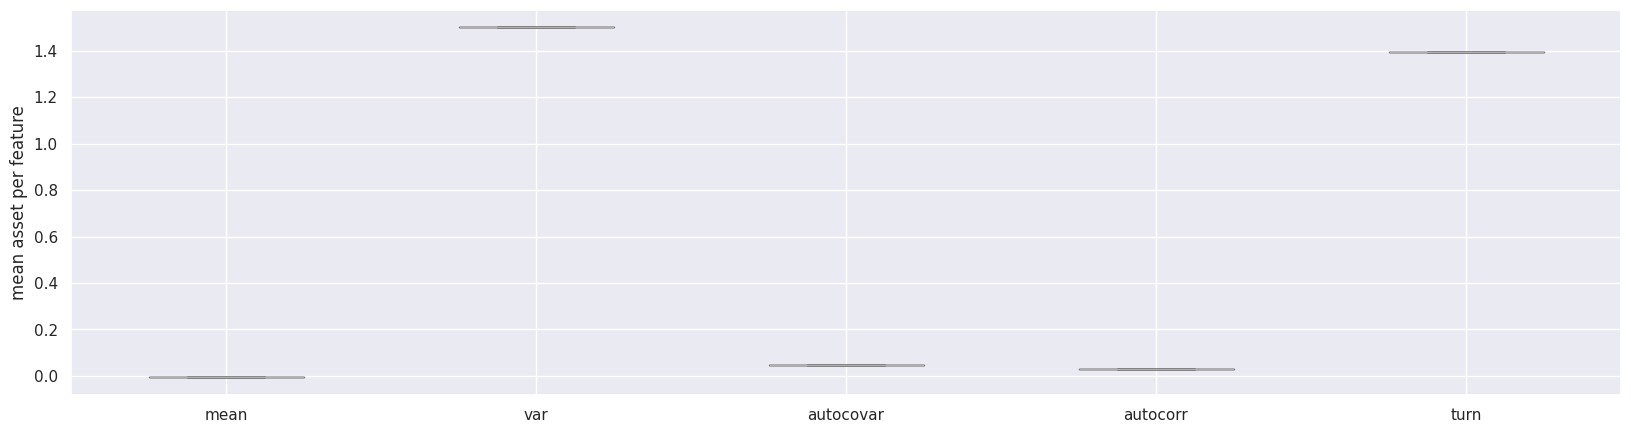

In [18]:
_, ax = plt.subplots()
mean_asset_stats_per_feature[
    ["mean", "var", "autocovar", "autocorr", "turn"]
].boxplot(ylabel="mean asset per feature", ax=ax)

In [19]:
mean_feature_stats_per_asset = feature_stats.groupby(level=0).mean()
display(mean_feature_stats_per_asset)

,count,eff_count,mean,var,autocovar,autocorr,turn
1464553467,174076.0,174076.0,-0.003536,1.491278,0.045816,0.030723,1.392320
1467591036,173957.0,173957.0,-0.008110,1.508919,0.048123,0.031893,1.391479


<Axes: ylabel='mean feature per asset'>

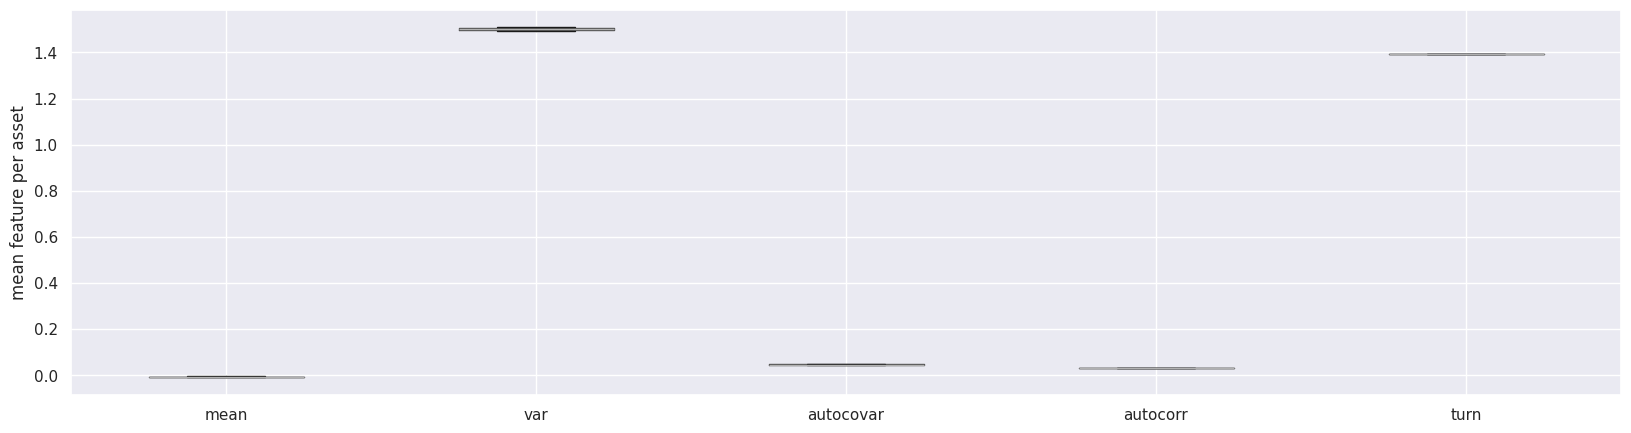

In [20]:
_, ax = plt.subplots()
mean_feature_stats_per_asset[
    ["mean", "var", "autocovar", "autocorr", "turn"]
].boxplot(ylabel="mean feature per asset", ax=ax)

In [21]:
mean_feature_corr = costatis.compute_mean_pearson_correlation_by_group(
    feature_df, 1
)
# Plot heatmap if correlation matrix contains >1 feature.
if mean_feature_corr.shape[1] > 1:
    coplotti.plot_heatmap(mean_feature_corr, mode="clustermap", figsize=(10, 10))

/venv/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


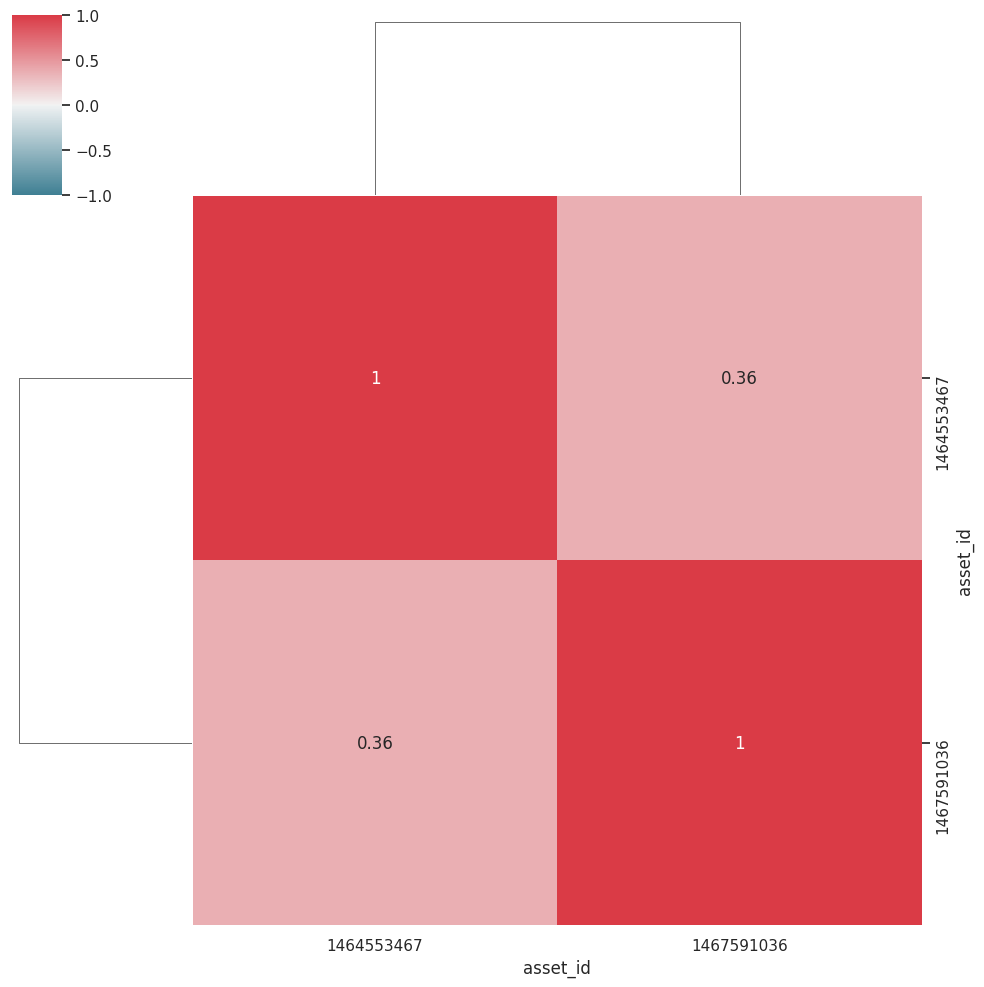

In [22]:
mean_asset_corr = costatis.compute_mean_pearson_correlation_by_group(
    feature_df, 0
)
coplotti.plot_heatmap(mean_asset_corr, mode="clustermap", figsize=(10, 10))

# Per-asset cross-sectional feature analysis (all features for a single asset)

In [23]:
single_asset_feature_df = feature_df.T.xs(default_config["asset_id"], level=1).T

In [24]:
single_asset_feature_df_corr = single_asset_feature_df.corr()
# Plot heatmap if correlation matrix contains >1 feature.
if single_asset_feature_df_corr.shape[1] > 1:
    coplotti.plot_heatmap(
        single_asset_feature_df.corr(), mode="clustermap", figsize=(10, 10)
    )
# Alternative method (prints correlation matrix and does not reorder columns):
# coplotti.plot_correlation_matrix(features)

[1.0, 1.0, 1.0]

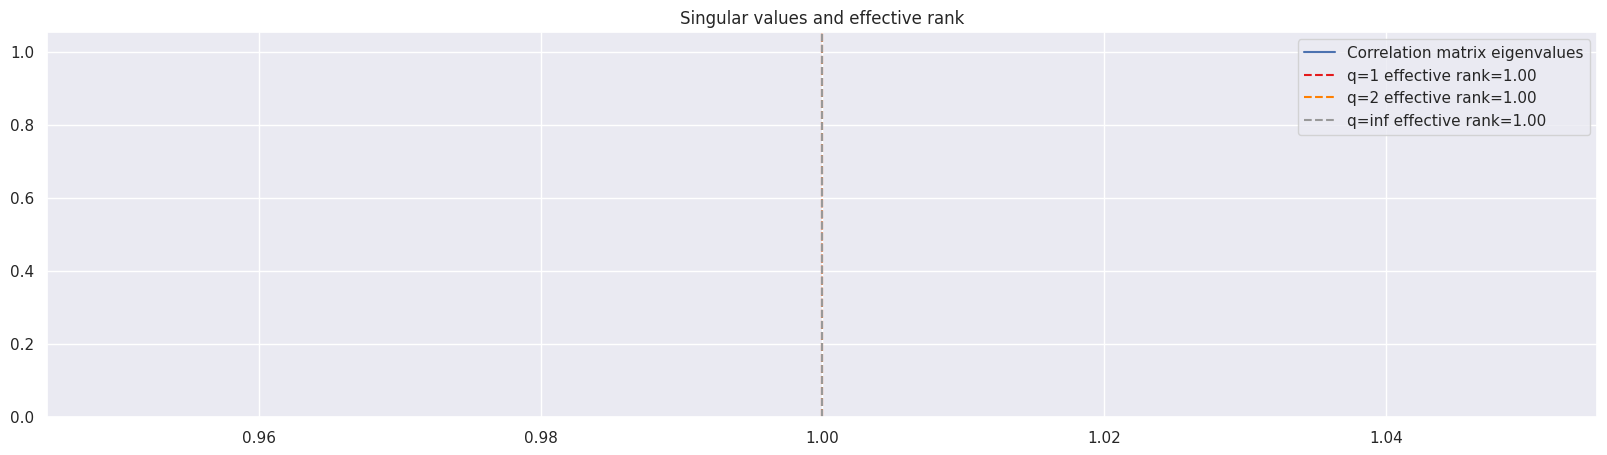

In [25]:
coplotti.plot_effective_correlation_rank(single_asset_feature_df)

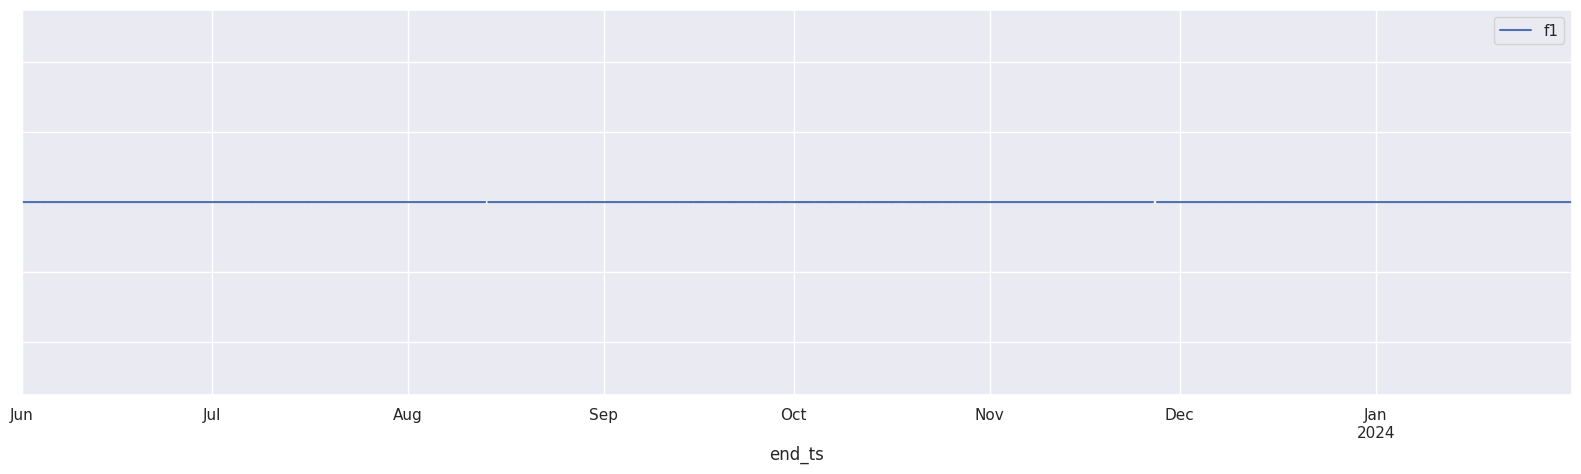

In [26]:
coplotti.plot_projection(
    single_asset_feature_df.resample(default_config["resampling_frequency"]).sum(
        min_count=1
    )
)

In [27]:
# sc = dtfmod.StatsComputer()
# single_asset_feature_df.apply(sc.compute_summary_stats).round(3)
# Alternative method:
single_asset_feature_df.apply(costatis.compute_moments)

,f1
mean,-0.008110
std,1.228357
skew,0.016697
kurtosis,0.820156


# Single feature analysis

In [28]:
feature = default_config["single_feature_column_name"]
_LOG.info("feature=%s", feature)

INFO  feature=f1


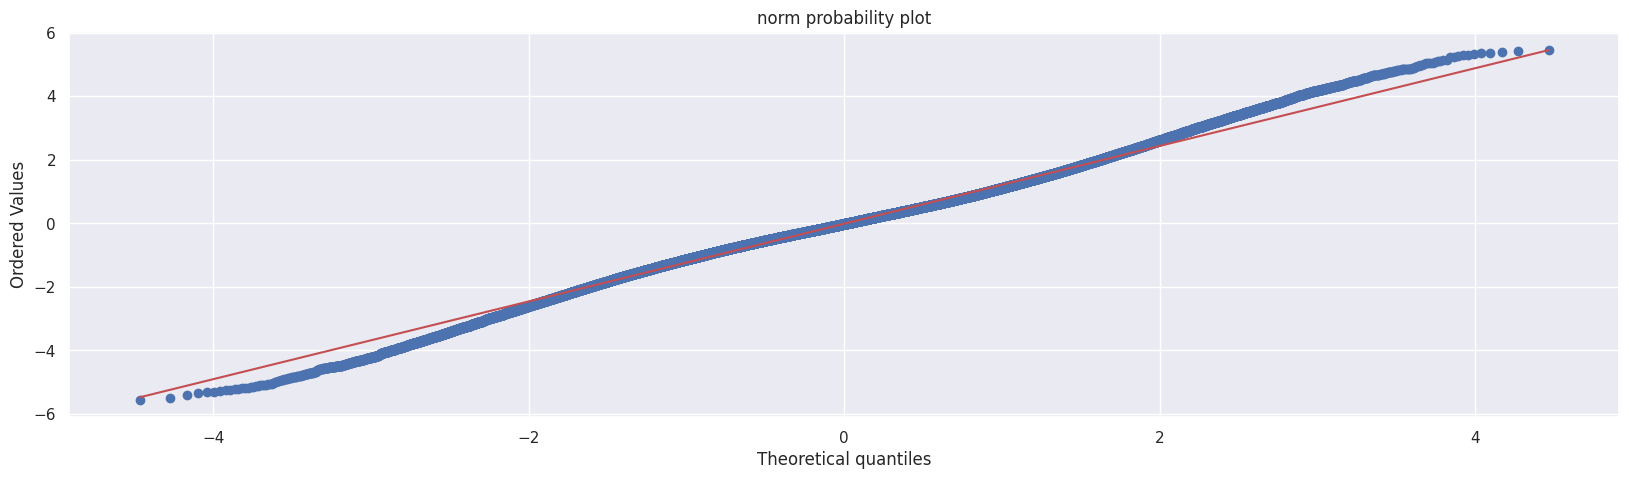

In [29]:
coplotti.plot_qq(single_asset_feature_df[feature])

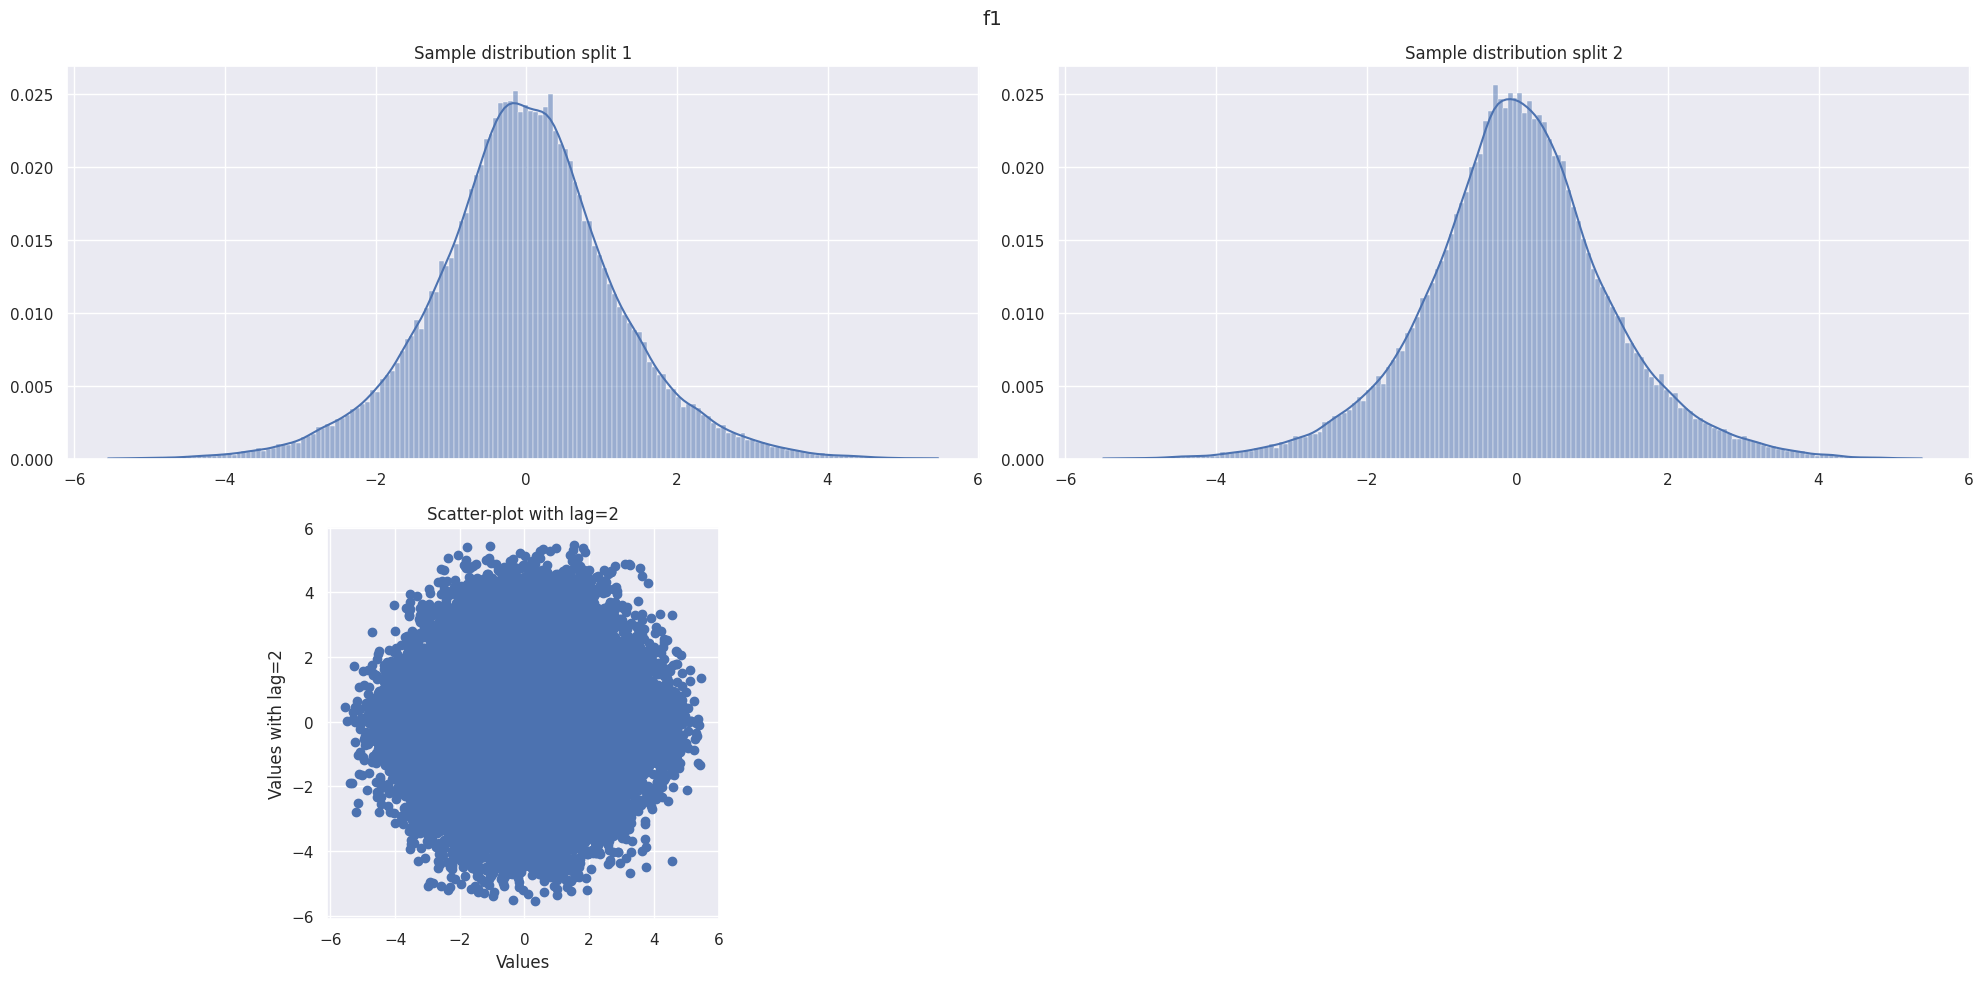

In [30]:
coplotti.plot_histograms_and_lagged_scatterplot(
    single_asset_feature_df[feature], lag=2, figsize=(20, 10)
)

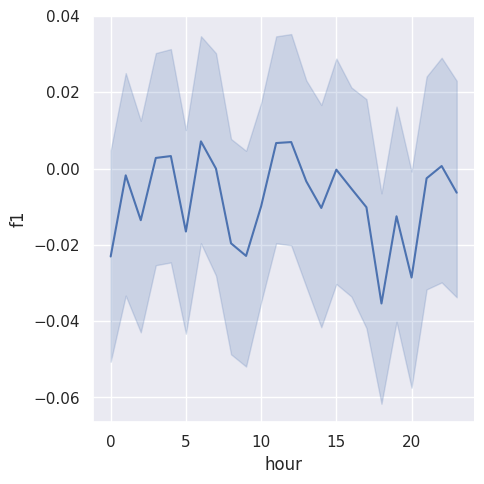

In [31]:
coplotti.plot_time_series_by_period(
    single_asset_feature_df[feature],
    "hour",
)

# Feature cross-section (single feature across all assets)

In [32]:
xs_feature_df = feature_df[feature]

asset_id,1464553467,1467591036
asset_id,,
1464553467,1.000000,0.360535
1467591036,0.360535,1.000000


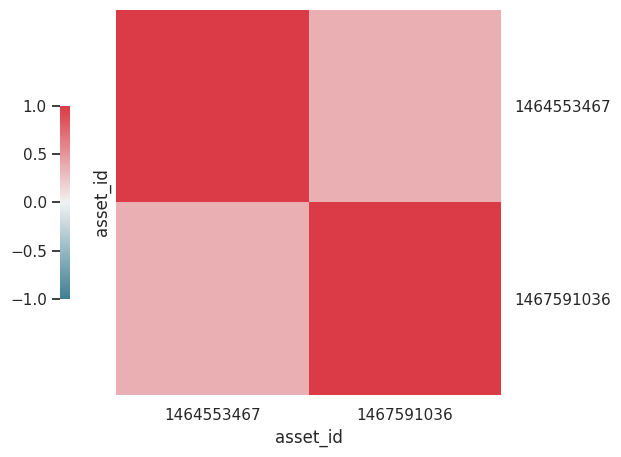

In [33]:
coplotti.plot_correlation_matrix(xs_feature_df)

[1.8713643315804314, 1.7699345210469046, 1.470010230525826]

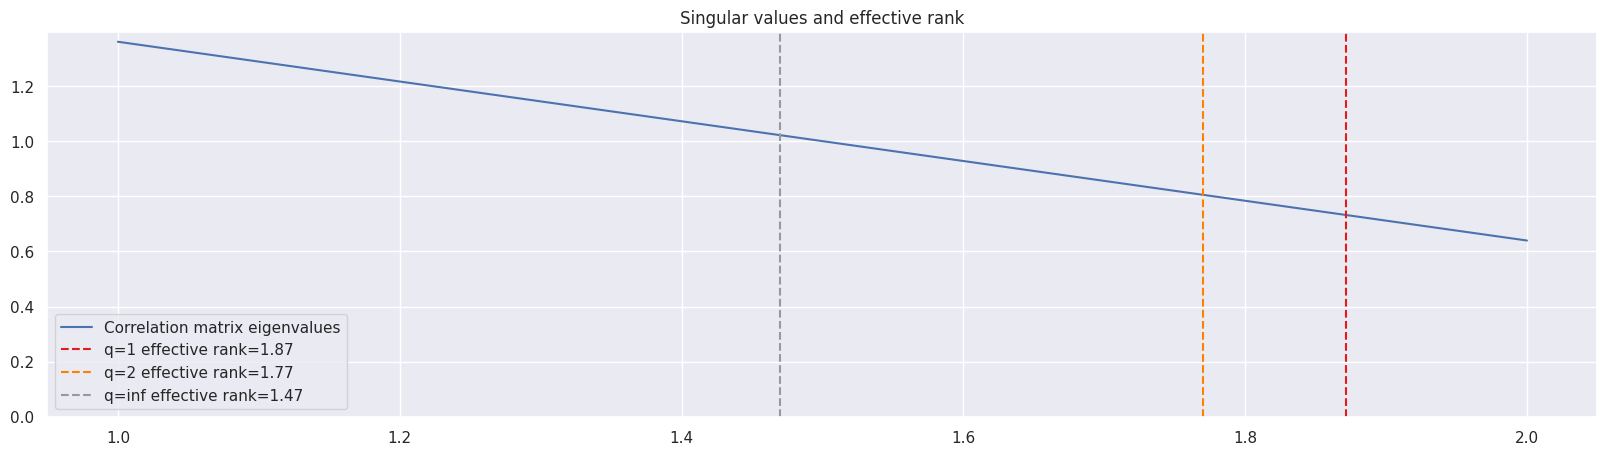

In [34]:
coplotti.plot_effective_correlation_rank(xs_feature_df)